In [230]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
import numpy as np
from sklearn.datasets import make_regression

from csv_reader import *
from csv_setup import *

bike_sharing_df = get_bike_sharing_df_clean()
print(bike_sharing_df)

plt.rcParams.update({'font.size': 18})

       hr  holiday  workingday  weathersit   atemp   hum  windspeed  cnt  \
0       0        0           0           1  0.2879  0.81     0.0000   16   
1       1        0           0           1  0.2727  0.80     0.0000   40   
2       2        0           0           1  0.2727  0.80     0.0000   32   
3       3        0           0           1  0.2879  0.75     0.0000   13   
4       4        0           0           1  0.2879  0.75     0.0000    1   
...    ..      ...         ...         ...     ...   ...        ...  ...   
17374  19        0           1           2  0.2576  0.60     0.1642  119   
17375  20        0           1           2  0.2576  0.60     0.1642   89   
17376  21        0           1           1  0.2576  0.60     0.1642   90   
17377  22        0           1           1  0.2727  0.56     0.1343   61   
17378  23        0           1           1  0.2727  0.65     0.1343   49   

       no_snow  medium_snow  heavy_snow  
0            0            0           1  
1  

In [152]:
def rmsle(y_log, y0_log):
    return np.sqrt(np.mean(np.square(y_log - y0_log)))

In [192]:
# Train and test data preperation
# We split the data first, then we take the log of the cnt, which represents the number of bikes on a given day

scaler = StandardScaler()

# Count variable that we are going to be predicting
Y = bike_sharing_df.cnt
# Features that we are going to be fitting
X = bike_sharing_df.loc[:].drop(columns=["cnt"])

# Split the data
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 1)

# log of each of the cnt
# this will normalize the variable that we are trying to predict
y_train_log = y_train.apply(lambda x:np.log1p(x))
y_test_log = y_test.apply(lambda x:np.log1p(x))

# y_train_log = y_train
# y_test_log = y_test

preScale_X_train = X_train
preScale_X_test = x_test


X_train = scaler.fit_transform(X_train)
x_test = scaler.fit_transform(x_test)


# y_test = y_test.reset_index().drop('index',axis = 1)
# y_train = y_train.reset_index().drop('index',axis = 1)

parameters = {
         'lasso__alpha':np.logspace(-5, 5, 100),
    }


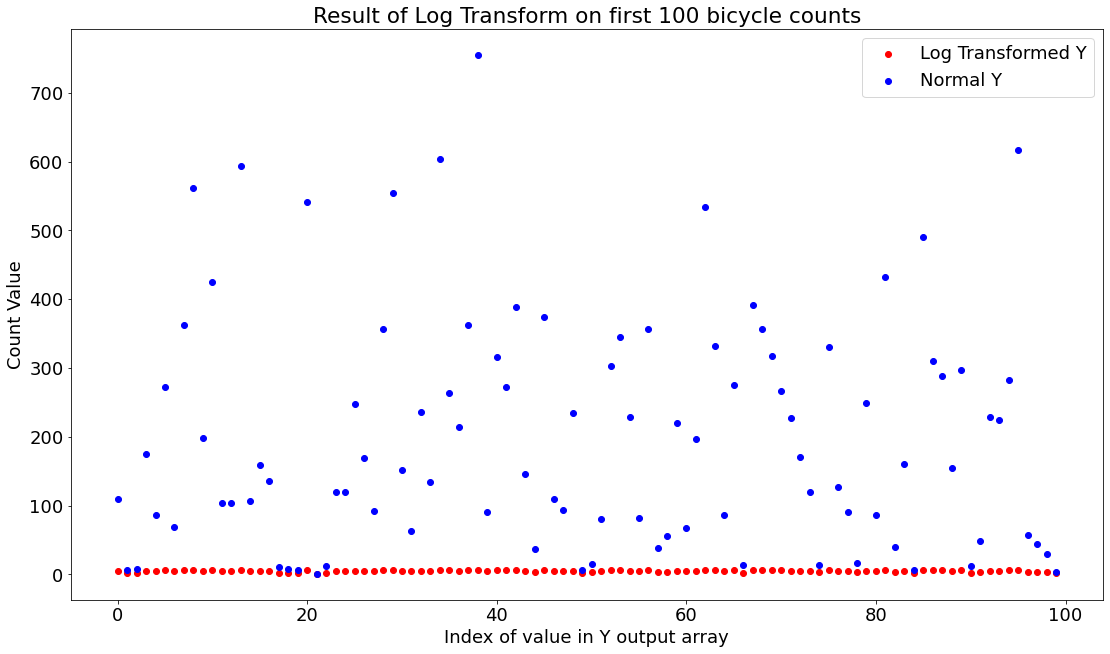

In [193]:
plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)
xvalues = []
i = 0
for a in range(0, 100):
    xvalues.append(a)
    i = i+1

plt.scatter(xvalues,y_train_log[:100],color="red", label="Log Transformed Training")
plt.scatter(xvalues,y_train[:100],color="blue", label="Normal Training")
ax = plt.gca()

ax.legend(("Log Transformed Y", "Normal Y"))
plt.xlabel('Index of value in Y output array')
plt.ylabel('Count Value');
plt.title('Result of Log Transform on first 100 bicycle counts')
plt.show()

7445     20
13512     5
6158      4
13205    10
1616     20
         ..
10955    15
17289     6
5192      6
12172     9
235       2
Name: hr, Length: 11643, dtype: int64


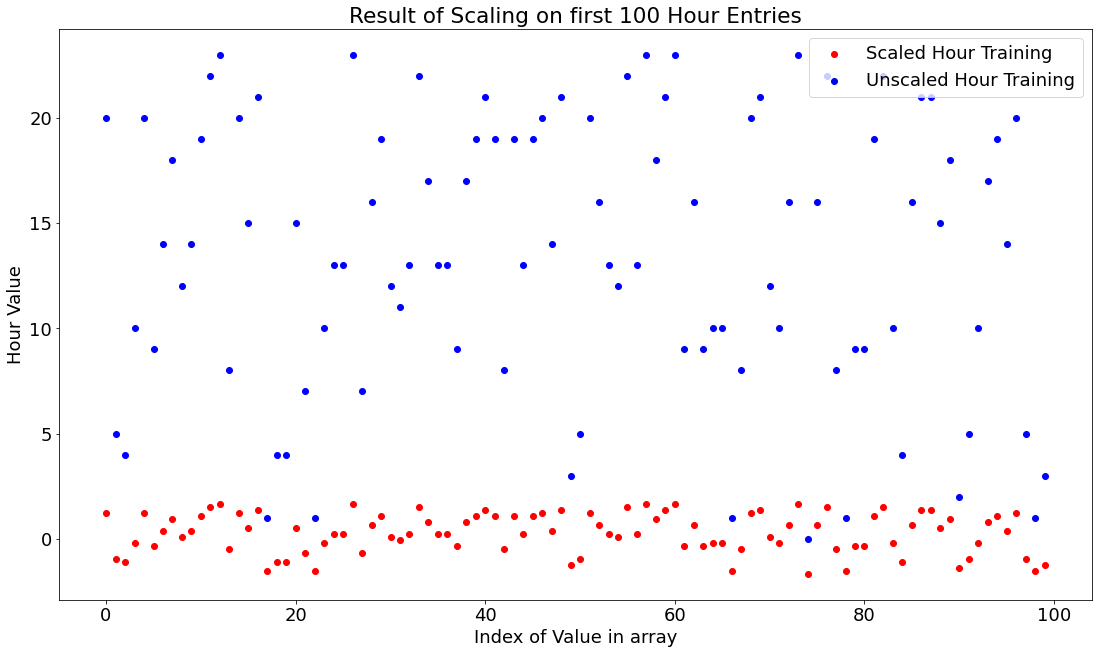

In [194]:
plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)
xvalues = []
i = 0
test = []

print(preScale_X_train['hr'])
        
for a in range(0, 100):
    xvalues.append(a)
    i = i+1
plt.scatter(xvalues,X_train[:,0][:100],color="red", label="Log Transformed Training")
plt.scatter(xvalues,preScale_X_train['hr'][:100],color="blue", label="Normal Training")
ax = plt.gca()

plt.xlabel('Index of Value in array')
plt.ylabel('Hour Value');
plt.title('Result of Scaling on first 100 Hour Entries')
ax.legend(("Scaled Hour Training ", "Unscaled Hour Training"), loc='upper right')

plt.show()

In [195]:
# This function uses the original count values
# The MSE will be extremely high

def LassoNormal(x_train, y_train):
    # 0-9 to show all iterations that are done
    # Now we are using just the neg_mean_squared_error to find the best coeff
    pipe = make_pipeline(scaler, Lasso(fit_intercept=True))
    gs = GridSearchCV(pipe,parameters, scoring='neg_mean_squared_error', cv=5)
    gs.fit(x_train,y_train)
    return gs

In [196]:
def LassoLog(x_train, y_train):
    # Here we are cross validating as well as fitting the model
    # We are using the neg_mean_squared_log_error to find the best alpha
    pipe = make_pipeline(scaler, Lasso(fit_intercept=True))
    gs = GridSearchCV(pipe,parameters, scoring='neg_mean_squared_log_error', cv=5)
    gs.fit(x_train,y_train)
    return gs


In [197]:
gsLasso = LassoNormal(X_train, y_train)

gsLassoLog = LassoLog(X_train, y_train_log)

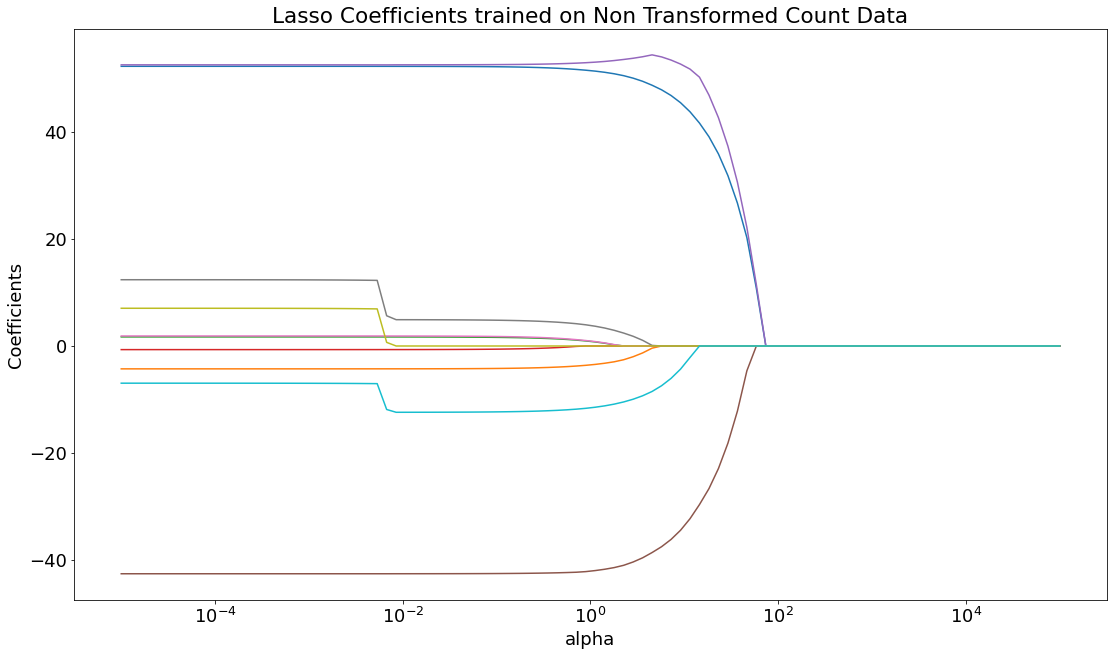

In [221]:


scaler = StandardScaler()
lasso = Lasso(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)
coefs = []
# print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)
parameters = {'lasso__alpha':np.logspace(-5, 5, 100)}
# model = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
# model.fit(X_train,y_train)
for a in  parameters['lasso__alpha']:
    pipe.set_params(lasso__alpha=a)
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)

ax = plt.gca()
ax.plot(np.logspace(-5, 5, 100), coefs)
ax.set_xscale('log')
plt.title('Lasso Coefficients trained on Non Transformed Count Data')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients');

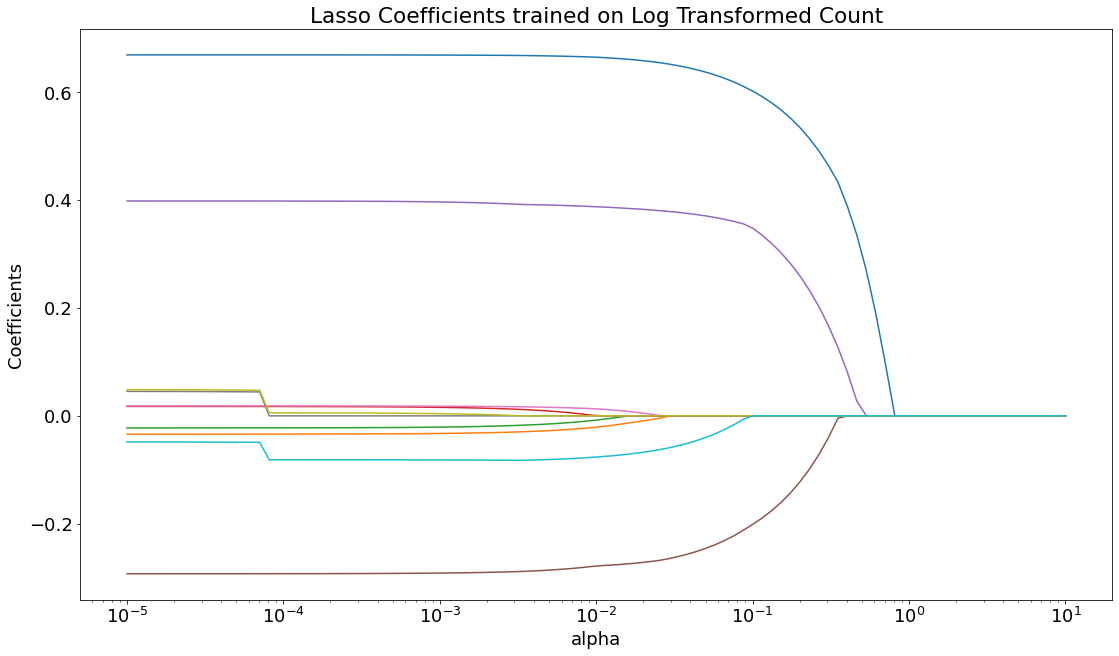

In [219]:
scaler = StandardScaler()
lasso = Lasso(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)
coefs = []
# print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)
parameters = {'lasso__alpha':np.logspace(-5, 1, 100)}
# model = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
# model.fit(X_train,y_train)
for a in  parameters['lasso__alpha']:
    pipe.set_params(lasso__alpha=a)
    pipe.fit(X_train, y_train_log)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure()
ax = plt.gca()
ax.plot(np.logspace(-5,1, 100), coefs)
ax.set_xscale('log')
plt.gcf().set_size_inches(18.5, 10.5)

plt.title('Lasso Coefficients trained on Log Transformed Count')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients');

In [222]:
print("Best alpha Log: " + str(gsLassoLog.best_params_['lasso__alpha']))
print("Best coeff Log: " + str(gsLassoLog.best_estimator_.named_steps['lasso'].coef_))

print("\nBest alpha Normal: " + str(gsLasso.best_params_['lasso__alpha']))
print("Best coeff Normal: " + str(gsLasso.best_estimator_.named_steps['lasso'].coef_))



Best alpha Log: 1e-05
Best coeff Log: [ 0.6694551  -0.0339065  -0.02233087  0.01747576  0.39851532 -0.29281234
  0.0184364   0.04541777  0.04863693 -0.04833305]

Best alpha Normal: 0.013530477745798061
Best coeff Normal: [ 52.29948234  -4.26605973   1.68894614  -0.66694391  52.59148646
 -42.59361187   1.85909999   4.91396484  -0.         -12.39458015]


In [223]:
# Average of Y's
np.mean(y_train_log)

4.5717683471239114

In [224]:
print('\nCoefficients  [lasso] Log')

yvalues1 = gsLassoLog.best_estimator_.named_steps['lasso'].coef_
for i in range(0,10):
    print('   Feature %f:  %.2f'%(i,\
                    yvalues1[i]))

print('\nCoefficients  [lasso] Normal')

yvalues2 = gsLasso.best_estimator_.named_steps['lasso'].coef_
for i in range(0,10):
    print('   Feature %f:  %.2f'%(i,\
                    yvalues2[i]))
xvalues = []
xvalues = [1,2,3,4,5,6,7,8,9,10]
   


Coefficients  [lasso] Log
   Feature 0.000000:  0.67
   Feature 1.000000:  -0.03
   Feature 2.000000:  -0.02
   Feature 3.000000:  0.02
   Feature 4.000000:  0.40
   Feature 5.000000:  -0.29
   Feature 6.000000:  0.02
   Feature 7.000000:  0.05
   Feature 8.000000:  0.05
   Feature 9.000000:  -0.05

Coefficients  [lasso] Normal
   Feature 0.000000:  52.30
   Feature 1.000000:  -4.27
   Feature 2.000000:  1.69
   Feature 3.000000:  -0.67
   Feature 4.000000:  52.59
   Feature 5.000000:  -42.59
   Feature 6.000000:  1.86
   Feature 7.000000:  4.91
   Feature 8.000000:  -0.00
   Feature 9.000000:  -12.39


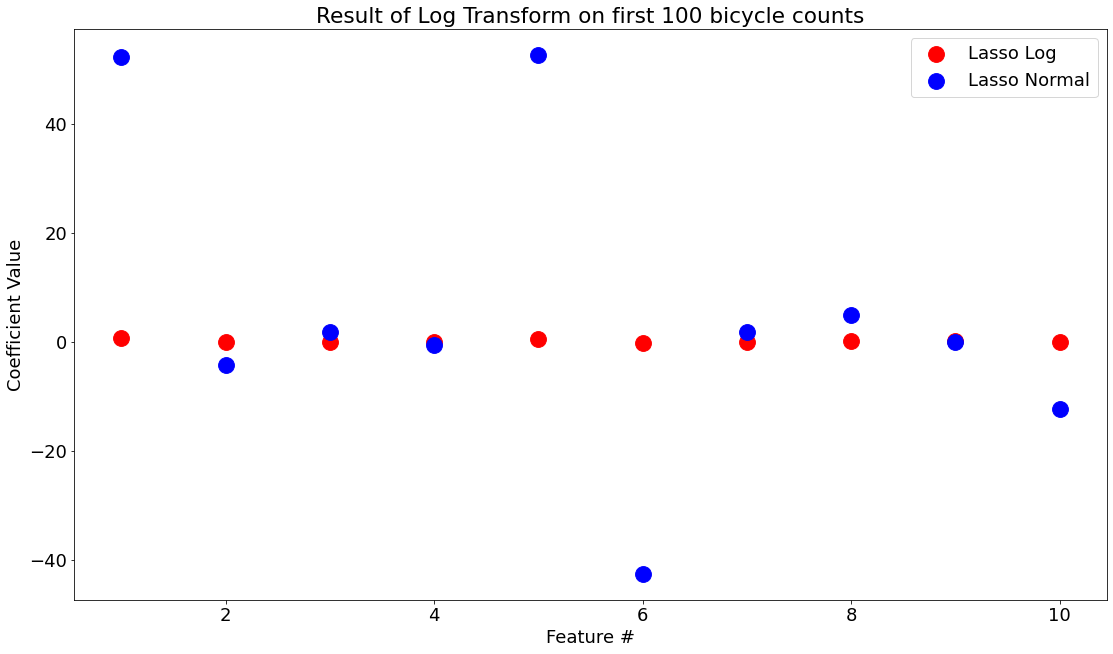

In [225]:
# This is a plot showing the difference between the coefficient values.
# The largest difference being between the value of the coefficients for features 5 and 6

plt.figure()
plt.gcf().set_size_inches(18.5, 10.5)

plt.scatter(xvalues,yvalues1,s=250,color="red", label="Lasso Log")
plt.scatter(xvalues,yvalues2,s=250,color="blue", label="Lasso Normal")
ax = plt.gca()

ax.legend(("Lasso Log", "Lasso Normal"))
plt.xlabel('Feature #')
plt.ylabel('Coefficient Value');
plt.title('Result of Log Transform on first 100 bicycle counts')

plt.show()

In [226]:
y_pred = gsLassoLog.predict(x_test)

mse_test_using_lasso = mean_squared_error(y_test_log,y_pred)
print('\nTest set MSE using Log Lasso coefficients: %.2f'%mse_test_using_lasso)
print('Test set RMLSE using Log Lasso coefficients %.2f'%rmsle(y_test_log, y_pred))


# One reason for the MSE being unreasonably high here is the high variance in the data
# Compared to that of the log transformed MSE of the Log Lasso
y_pred = gsLasso.predict(x_test)
mse_test_using_lasso = mean_squared_error(y_test,y_pred)
print('\nTest set MSE using Normal Lasso coefficients: %.2f'%mse_test_using_lasso)
print('Once again, we cannot use the Normal Lasso coefficients to calculate RMLSE because it predicts negative numbers')


Test set MSE using Log Lasso coefficients: 1.11
Test set RMLSE using Log Lasso coefficients 1.05

Test set MSE using Normal Lasso coefficients: 22851.61
Once again, we cannot use the Normal Lasso coefficients to calculate RMLSE because it predicts negative numbers


In [227]:
lm = gsLassoLog

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)


print('R squared statistic for Log Lasso')
print('Train Score: ')
print(r2_score(y_train_log, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test_log, y_test_pred))

R squared statistic for Log Lasso
Train Score: 
0.45624634115987783

Test Score: 
0.4532696686580575


In [228]:
lm = gsLasso

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)

print('R squared statistic for Normal Lasso')

print('Train Score: ')
print(r2_score(y_train, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test, y_test_pred))

R squared statistic for Normal Lasso
Train Score: 
0.33008079156523573

Test Score: 
0.3308423402041546
